In [1]:
## Every notebook should start with this header
# The next lines mean that changes in Python files are instantaneously applied
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from pathlib import Path

# As a sanity check, print out the current working directory
print(f"Running in {Path('').absolute()}")

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from cfspopcon.named_options import AtomicSpecies
from cfspopcon.unit_handling import ureg
from cfspopcon.unit_handling import dimensionless_magnitude as dmag
import cfspopcon
import extended_lengyel
plt.rcParams['mathtext.default'] = 'regular'

Running in /Users/tbody/Projects/extended-lengyel/notebooks


In [2]:
impurity_weights_list = extended_lengyel.read_config(
    elements        = ["AUG_39520_t5s"],
)["impurity_weights_list"]

impurity_species_list = extended_lengyel.read_config(
    elements        = ["AUG_39520_t5s"],
)["impurity_species_list"]

impurity_weights_list = xr.DataArray(impurity_weights_list, coords=dict(dim_species = impurity_species_list))
impurity_species_list = xr.DataArray([AtomicSpecies[k] for k in impurity_species_list], coords=dict(dim_species = impurity_species_list))

In [3]:
def run_model(
    **overrides
):
    algorithm = cfspopcon.CompositeAlgorithm.from_list([
        "calc_upstream_field",
        "calc_cylindrical_edge_safety_factor",
        "calc_fieldline_pitch_at_omp",
        "set_radas_dir",
        "read_atomic_data",
        "build_mixed_seeding_L_int_integrator",
        "calc_kappa_e0",
        "build_mixed_seeding_mean_charge_interpolator",
        "calc_momentum_loss_from_cc_fit",
        "calc_power_loss_from_cc_fit",
        "calc_electron_temp_from_cc_fit",
        "run_extended_lengyel_model_with_S_Zeff_and_alphat_correction",
        "calc_sound_speed_at_target",
        "calc_target_density",
        "calc_flux_density_to_pascals_factor",
        "calc_parallel_to_perp_factor",
        "calc_ion_flux_to_target",
        "calc_divertor_neutral_pressure",
        "calc_heat_flux_perp_to_target"
    ])

    data_vars = extended_lengyel.read_config(
        elements        = ["base", "machine_geometry", "field_at_omp", "AUG_39520_t5s"],
        keys            = algorithm.input_keys,
        allowed_missing = algorithm.default_keys,
        overrides       = overrides,
    )

    data_vars["impurity_weights_list"] = xr.DataArray(data_vars["impurity_weights_list"],
                                                      coords=dict(dim_species = data_vars["impurity_species_list"]))
    data_vars["impurity_species_list"] = xr.DataArray([AtomicSpecies[k] for k in data_vars["impurity_species_list"]],
                                                      coords=dict(dim_species = data_vars["impurity_species_list"]))

    ds = xr.Dataset(data_vars=data_vars)
    algorithm.validate_inputs(ds)
    ds = algorithm.update_dataset(ds)

    return ds

point = run_model()

In [4]:
from cfspopcon.unit_handling import magnitude_in_units as mag

measurement_data = extended_lengyel.read_config(elements = ["AUG_39520_t5s", "AUG_39520_t5s_reference"])

print(point["separatrix_electron_density"].item())
pdiv = measurement_data["divertor_neutral_pressure"]
print((2.65 * ureg.n19 * mag(pdiv, ureg.Pa)**0.31).to(ureg.m**-3))

3.3e+19 / meter ** 3
3.2334004188100555e+19 / meter ** 3


In [5]:
print(point["cylindrical_safety_factor"].item().to(""))
print(point["B_t_out_mid"].item().to("T"))
print(point["separatrix_average_poloidal_field"].item().to("T"))
print(point["B_pol_out_mid"].item().to("T"))
print(point["fieldline_pitch_at_omp"].item().to(""))

3.729030300985294 dimensionless
1.9186046511627908 tesla
0.2998126757627626 tesla
0.3997502343503501 tesla
4.90257910962459 dimensionless


In [6]:
c_z = point["impurity_fraction"] * point["impurity_weights_list"]
print(f"Nitrogen concentration: {c_z.sel(dim_species="Nitrogen").item():.2}")
print(f"Argon concentration: {c_z.sel(dim_species="Argon").item():.2}")
print(f"alpha-t: {point["alpha_t"].item():.2}")
print(f"Zeff: {point["z_effective"].item():.2}")
print(f"lambda-q: {point["lambda_q"].item().to("mm"):.2}")
print(f"target electron temp: {point["target_electron_temp"].item():.2}")
print(f"momentum loss: {point["SOL_momentum_loss_fraction"].item():.2}")
print(f"power loss: {point["SOL_power_loss_fraction"].item():.2}")
print(f"separatrix temperature: {point["separatrix_electron_temp"].item():.1f}")
print(f"heat flux perp to target: {point["heat_flux_perp_to_target"].item().to("MW/m^2"):.1f}")
print(f"neutral_pressure_in_divertor: {point["neutral_pressure_in_divertor"].item().to("Pa"):.1f}")
print(f"power radiated above X-point: {(point["radiated_fraction_above_xpt"] * point["power_crossing_separatrix"] * point["fraction_of_P_SOL_to_divertor"]).item().to("MW"):.1f}")
print(f"power radiated below X-point: {(point["radiated_fraction_below_xpt"] * (1 - point["radiated_fraction_above_xpt"]) * point["power_crossing_separatrix"] * point["fraction_of_P_SOL_to_divertor"]).item().to("MW"):.1f}")

Nitrogen concentration: 1.7 percent
Argon concentration: 0.084 percent
alpha-t: 0.39 dimensionless
Zeff: 1.3 dimensionless
lambda-q: 3.8 millimeter
target electron temp: 2.0 electron_volt
momentum loss: 0.58 dimensionless
power loss: 0.95 dimensionless
separatrix temperature: 86.3 electron_volt
heat flux perp to target: 0.6 megawatt / meter ** 2
neutral_pressure_in_divertor: 1.4 pascal
power radiated above X-point: 0.1 megawatt
power radiated below X-point: 3.0 megawatt


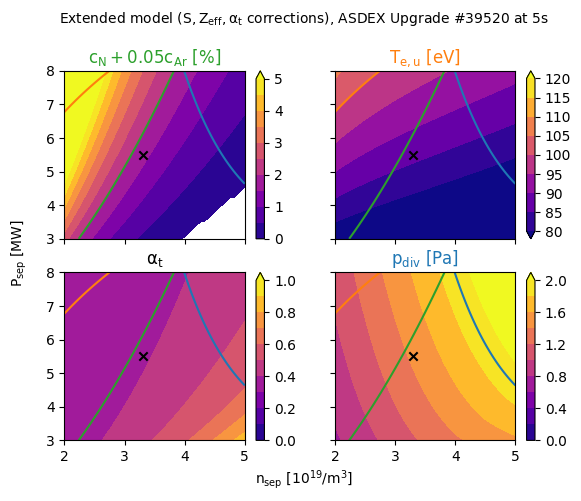

In [7]:
def transpose(array):
    return array.transpose("dim_y", "dim_x")

selected_x = mag(measurement_data["separatrix_electron_density"], ureg.n19)
selected_y = mag(measurement_data["power_crossing_separatrix"], ureg.MW)
xlabel = "$n_{sep}$ $[10^{{19}}/m^3]$"
ylabel = "$P_{sep}$ $[MW]$"

cmap = "plasma"

cz_color = "C2"
Tu_color = "C1"
p0_color = "C0"

ds = run_model(
    separatrix_electron_density = extended_lengyel.promote_to_coordinate(np.linspace(2, 5), ureg.n19, dims="x"),
    power_crossing_separatrix   = extended_lengyel.promote_to_coordinate(np.linspace(3, 8), ureg.MW, dims="y"),
)

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

x = mag(ds["separatrix_electron_density"], ureg.n19)
y = mag(ds["power_crossing_separatrix"], ureg.MW)

im = axs[0][0].contourf(x, y, mag(transpose(ds["impurity_fraction"]), "%"), levels=np.linspace(0, 5, num=11), extend="max", cmap=cmap)
plt.colorbar(im, ax = axs[0][0])
axs[0][0].set_title("$c_{N} + 0.05c_{Ar}$ [%]", color=cz_color)

im = axs[0][1].contourf(x, y, mag(transpose(ds["separatrix_electron_temp"]), "eV"), levels=np.linspace(80, 120, num=9), extend="both", cmap=cmap)
plt.colorbar(im, ax = axs[0][1])
axs[0][1].set_title("$T_{e,u}$ $[eV]$", color=Tu_color)

im = axs[1][0].contourf(x, y, mag(transpose(ds["alpha_t"]), ""), levels=np.linspace(0, 1, num=11), extend="max", cmap=cmap)
plt.colorbar(im, ax = axs[1][0])
axs[1][0].set_title("$\\alpha_{t}$")

im = axs[1][1].contourf(x, y, mag(transpose(ds["neutral_pressure_in_divertor"]), "Pa"), levels=np.linspace(0, 2, num=11), extend="max", cmap=cmap)
plt.colorbar(im, ax = axs[1][1])
axs[1][1].set_title("$p_{div}$ [Pa]", color=p0_color)

for ax in axs.flatten():
    ax.scatter(selected_x, selected_y, color="k", marker="x")
    ax.contour(x, y, mag(transpose(ds["impurity_fraction"]), "%"),
        levels=[mag(measurement_data["nitrogen_concentration"], "%")],
        colors=cz_color
    )
    ax.contour(x, y, mag(transpose(ds["separatrix_electron_temp"]), "eV"),
        levels=[mag(measurement_data["seperatrix_electron_temp"], "eV")],
        colors=Tu_color
    )
    ax.contour(x, y, mag(transpose(ds["neutral_pressure_in_divertor"]), "Pa"),
        levels=[mag(measurement_data["divertor_neutral_pressure"], "Pa")],
        colors=p0_color
    )

fig.text(0.5, 0.02, xlabel, ha='center')
fig.text(0.04, 0.5, ylabel, va='center', rotation='vertical')
fig.text(0.5, 0.98, "Extended model ($S, Z_{eff}, \\alpha_t$ corrections), ASDEX Upgrade #39520 at 5s", ha='center')

fig.savefig(extended_lengyel.directories.output_dir / "comparison_to_NF2024", dpi=300, bbox_inches="tight")